## Проект 5. Компьютер говорит "нет"
Выполнил Евгений Дементьев, поток - DST-PRO-18

### Загрузим необходимые библиотеки

In [3]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve


In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
!pip freeze > requirements.txt

### Загрузим данные

In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

### Посмотрим на данные

In [7]:
print('df_train: ', df_train.shape)
display(df_train.head())
print('df_test: ', df_test.shape)
display(df_test.head())

df_train:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


df_test:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


Информация о колонках в тренировочном датасете:

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

### Построим диаграмму и посмотрим, каких клиентов больше

<AxesSubplot:>

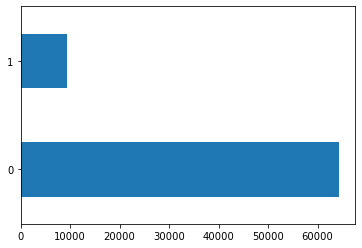

In [9]:
df_train['default'].value_counts().plot(kind = 'barh')

В тренировочном датасете больше всего недефолтных клиентов.

### Проверим наши данные на наличие пропусков

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

### Объединяем данные для обработки

In [12]:
df_test['default'] = 0 # заполняем переменную нудями
df_test['Train'] = 0 # указываем, что записи не принадлежат датасету train
df_train['Train'] = 1 # указываем, что записи принадлежат датасету train
df = df_train.append(df_test, sort = False).reset_index(drop=True) # объединяем датасеты в один

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [14]:
df.shape

(110148, 20)

Всего в выборке 110148 записей, из них: 
в тренировочной – 73799 клиентов,
в тестовой – 36349 клиентов.

В исходных данных 19 признаков:
1 временной ('app_date'),
6 бинарных ('sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'default'),
6 категориальных ('education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time')
6 числовых ('client_id', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income').

Пропуски встречаются только в признаке 'education' - 478 (в тренировочной - 307 пропусков, в тестовой - 171 пропуск).

client_id - числовой идентификационный признак, можно удалить.
default - целевая переменная, есть только в тренировочных данных.

Описание признаков

client_id - идентификатор клиента
app_date - дата подачи заявки
education - уровень образования
sex - пол заемщика
age - возраст заемщика
car - флаг наличия автомобиля
car_type - флаг автомобиля иномарки
decline_app_cnt - количество отказанных прошлых заявок
good_work - флаг наличия “хорошей” работы
score_bki - скоринговый балл по данным из БКИ
bki_request_cnt - количество запросов в БКИ
region_rating - рейтинг региона
home_address - категоризатор домашнего адреса
work_address - категоризатор рабочего адреса
income - доход заемщика
sna - связь заемщика с клиентами банка
first_time - давность наличия информации о заемщике
foreign_passport - наличие загранпаспорта
default - флаг дефолта по кредиту

### Работа с признаками

Введем новые признаки - день и месяц подачи заявки

In [15]:
from datetime import datetime
current_date = pd.to_datetime('20/01/2021')
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')
# Признак последовательности дней 
df['days'] = (df.app_date - df.app_date.min()).dt.days.astype('int')
df['app_date_month'] = df.app_date.dt.month

<AxesSubplot:xlabel='client_id', ylabel='days'>

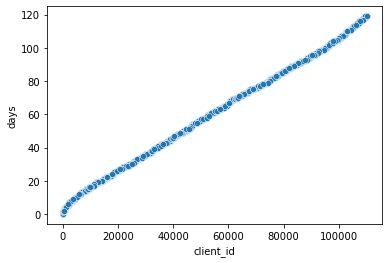

In [16]:
sns.scatterplot(x='client_id',y='days',data=df)

Идентификационый номер в 'client_id' прямо пропорционален дню подачи заявки, т.е. в банке велась последовательная нумерация заявок.

Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа.

In [17]:
date_cols = ['app_date']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] # default - целевая переменная
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'app_date_month']
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income', 'days'] # client_id исключили из списка

Построим графики для числовых переменных

Числовая переменная "age":
count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64


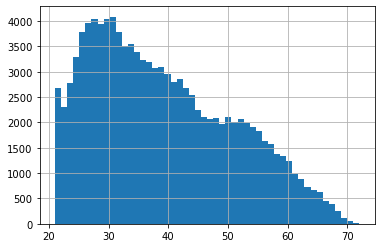

Числовая переменная "decline_app_cnt":
count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64


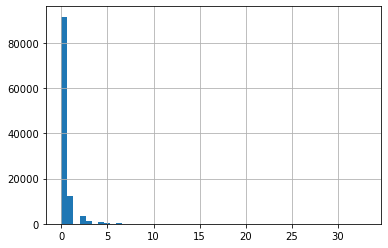

Числовая переменная "score_bki":
count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64


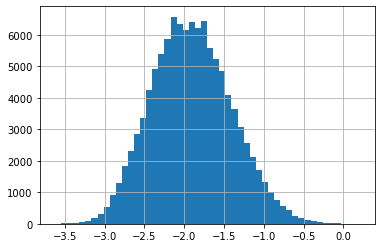

Числовая переменная "bki_request_cnt":
count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64


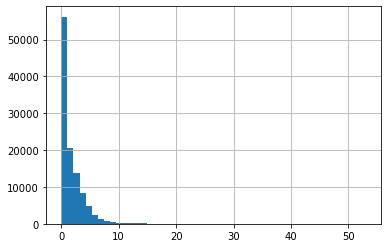

Числовая переменная "income":
count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64


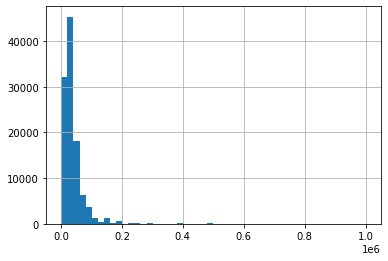

Числовая переменная "days":
count    110148.000000
mean         60.971466
std          32.076078
min           0.000000
25%          33.000000
50%          62.000000
75%          89.000000
max         119.000000
Name: days, dtype: float64


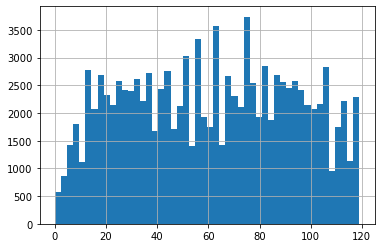

In [18]:
for col in num_cols:
    print('Числовая переменная "{a}":'.format(a=col)) # выводим название переменной
    print(df[col].describe())
    # выводим распределение заемщиков по признакам
    df[col].hist(bins=50)
    plt.show()
    

После построения гистограмм стало очевидно, что распределения всех числовых переменных имеют тяжёлый правый хвост. 
Построим графики распределения логарифмированных переменных:

Числовая переменная "age":
count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64


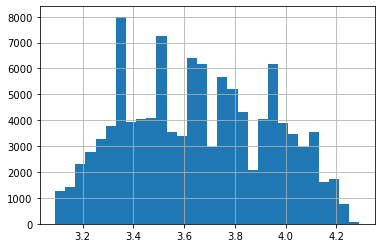

Числовая переменная "decline_app_cnt":
count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64


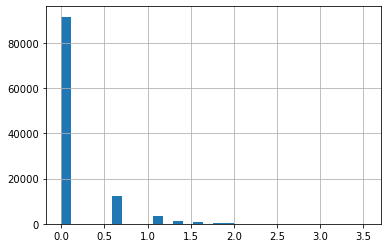

Числовая переменная "score_bki":
count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64


/Users/Evdem/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


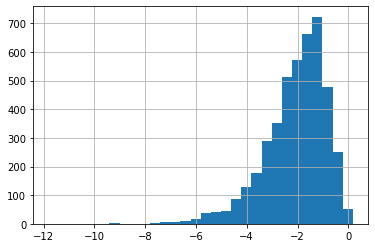

Числовая переменная "bki_request_cnt":
count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64


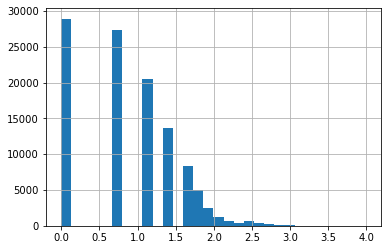

Числовая переменная "income":
count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64


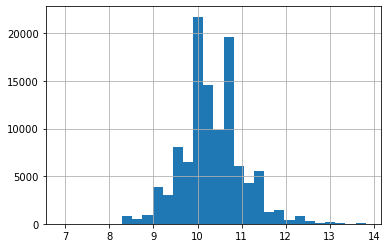

Числовая переменная "days":
count    110148.000000
mean         60.971466
std          32.076078
min           0.000000
25%          33.000000
50%          62.000000
75%          89.000000
max         119.000000
Name: days, dtype: float64


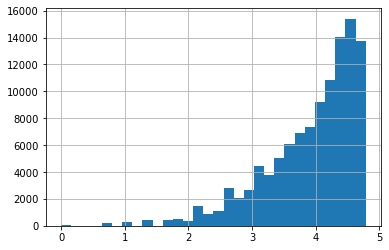

In [19]:
for col in num_cols:
    print('Числовая переменная "{a}":'.format(a=col)) # выводим название переменной
    print(df[col].describe())
    # выводим распределение заемщиков по признакам
    np.log(df[col]+1).hist(bins=30)
    plt.show()

### Работаем с категориальными признаками

Имеются пропуски в переменной 'education'. Найдем процентное соотношение пропусков от всех записей датасета:

In [20]:
print("Количество пропусков: "
      ,len(df[df['education'].isnull()]))

print("Доля записей с пропусками: "
      ,round(len(df[df['education'].isnull()])/len(df)*100, 2), "%")

Количество пропусков:  478
Доля записей с пропусками:  0.43 %


Доля записей с пропущенными значениями очень маленькая. Заполним пропущенные значения наиболее часто встречающимися значениями. Какое же значение самое частое? Посмотрим:

<AxesSubplot:>

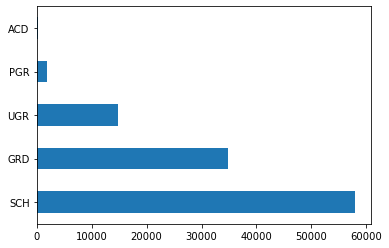

In [21]:
df['education'].value_counts().plot.barh()

Заполним отсутствующие значения, самым частым значением в 'education'. Это 'SCH'

In [22]:
df[df['education'].isnull()] = df[df['education'].isnull()].fillna('SCH')

Также преобразуем этот признак в числовой формат

In [23]:
label_encoder = LabelEncoder()
df['education'] = pd.Series(label_encoder.fit_transform(df['education']))

In [24]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,days,app_date_month
0,25905,2014-02-01,3,M,62,Y,Y,0,0,-2.008753,...,1,2,18000,4,1,N,0,1,31,2
1,63161,2014-03-12,3,F,59,N,N,0,0,-1.532276,...,2,3,19000,4,1,N,0,1,70,3
2,25887,2014-02-01,3,M,25,Y,N,2,0,-1.408142,...,1,2,30000,1,4,Y,0,1,31,2
3,16222,2014-01-23,3,F,53,N,N,0,0,-2.057471,...,2,3,10000,1,3,N,0,1,22,1
4,101655,2014-04-18,1,M,48,N,N,0,1,-1.244723,...,2,3,30000,1,4,Y,0,1,107,4


### Работаем с бинарными признанками

In [25]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [26]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,days,app_date_month
0,25905,2014-02-01,3,1,62,1,1,0,0,-2.008753,...,1,2,18000,4,1,0,0,1,31,2
1,63161,2014-03-12,3,0,59,0,0,0,0,-1.532276,...,2,3,19000,4,1,0,0,1,70,3
2,25887,2014-02-01,3,1,25,1,0,2,0,-1.408142,...,1,2,30000,1,4,1,0,1,31,2
3,16222,2014-01-23,3,0,53,0,0,0,0,-2.057471,...,2,3,10000,1,3,0,0,1,22,1
4,101655,2014-04-18,1,1,48,0,0,0,1,-1.244723,...,2,3,30000,1,4,1,0,1,107,4


### Оценка корреляций

<AxesSubplot:>

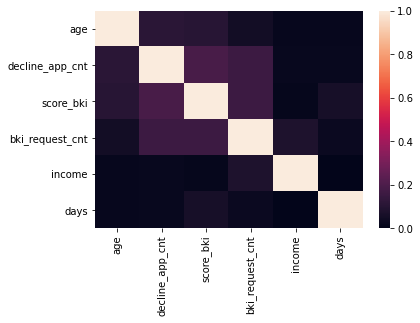

In [27]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

Данные имеют слабую корреляцию друг с другом

### Значимость непрерывных переменных

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

<AxesSubplot:title={'center':'Значимость числовых переменных'}>

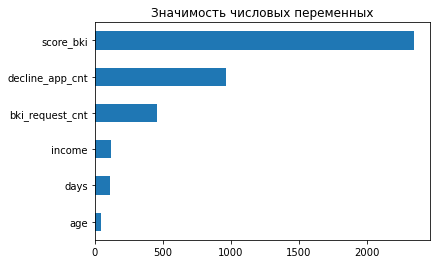

In [28]:
train_df = df[df['Train']==1]
imp_num = pd.Series(f_classif(train_df[num_cols], train_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость числовых переменных')

<AxesSubplot:title={'center':'Значимость бинарных признаков'}>

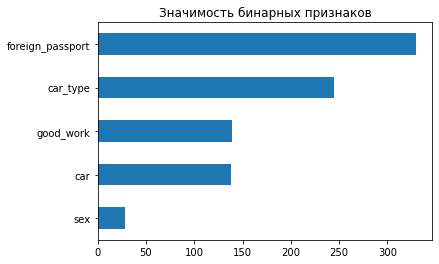

In [29]:
imp_bin = Series(f_classif(train_df[bin_cols], train_df['default'])[0], index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh', title = 'Значимость бинарных признаков')

<AxesSubplot:title={'center':'Значимость категориальных признаков'}>

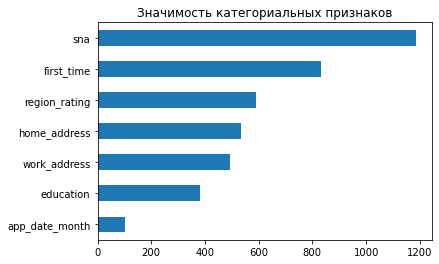

In [30]:
imp_cat = Series(f_classif(train_df[cat_cols], train_df['default'])[0], index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title = 'Значимость категориальных признаков')

### Подготовка данных к машинному обучению

Перед обучением регрессии нам следует стандартизировать числовые признаки, а также воспользоваться dummy-кодированием для категориальных переменных, то есть создать отдельную бинарную переменную для каждой категории.

LabelEncoder не совсем подходит для признаков с двумя и большим количеством категорий. Для того, чтобы мы смогли применять линейные модели на таких данных, нам необходим другой метод, который называется One-Hot Encoding. Смысл его точно такой же, как у dummy-кодирования.

In [31]:
# выделяем тренировочный датасет из датасета data
data_train = df[df['Train'] == 1]
data_train = data_train.drop(['client_id', 'app_date', 'Train'], axis=1)

In [32]:
data_train.shape

(73799, 19)

In [33]:
# проверяем тренировочный датасет
display(data_train.head(5))

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days,app_date_month
0,3,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0,31,2
1,3,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0,70,3
2,3,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0,31,2
3,3,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0,22,1
4,1,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0,107,4


In [34]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   education         73799 non-null  int64  
 1   sex               73799 non-null  int64  
 2   age               73799 non-null  int64  
 3   car               73799 non-null  int64  
 4   car_type          73799 non-null  int64  
 5   decline_app_cnt   73799 non-null  int64  
 6   good_work         73799 non-null  int64  
 7   score_bki         73799 non-null  float64
 8   bki_request_cnt   73799 non-null  int64  
 9   region_rating     73799 non-null  int64  
 10  home_address      73799 non-null  int64  
 11  work_address      73799 non-null  int64  
 12  income            73799 non-null  int64  
 13  sna               73799 non-null  int64  
 14  first_time        73799 non-null  int64  
 15  foreign_passport  73799 non-null  int64  
 16  default           73799 non-null  int64 

In [35]:
# преобразуем категориальные переменные методом One-Hot Encoding
data_train_cat = OneHotEncoder(sparse = False).fit_transform(data_train[cat_cols].values)

In [36]:
# проверяем
data_train_cat

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [37]:
# стандартизируем числовые переменные
data_train_num = StandardScaler().fit_transform(data_train[num_cols].values)

In [38]:
# проверяем
data_train_num

array([[ 1.97211528e+00, -3.42857656e-01, -2.08798701e-01,
        -4.44188844e-01, -5.00363267e-01, -9.35052171e-01],
       [ 1.71170539e+00, -3.42857656e-01,  7.47544609e-01,
         4.43888001e-01, -4.78702309e-01,  2.79081594e-01],
       [-1.23960668e+00,  2.14387966e+00,  9.96695659e-01,
        -4.44188844e-01, -2.40431770e-01, -9.35052171e-01],
       ...,
       [-7.18786904e-01, -3.42857656e-01,  7.86967388e-01,
         8.87926424e-01,  8.44826013e-02,  1.55547863e+00],
       [-8.92393496e-01, -3.42857656e-01,  8.53806107e-01,
         4.43888001e-01, -6.08668058e-01, -1.80673795e+00],
       [-4.58377015e-01, -3.42857656e-01,  2.81020871e-01,
        -1.50421558e-04, -3.48736561e-01, -1.21523689e+00]])

In [39]:
X = np.hstack([data_train_num, data_train[bin_cols].values, data_train_cat])
y = data_train['default'].values

In [40]:
# Разобьем данные для обучения и тестирования
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [41]:
# строим модель
model = LogisticRegression()
model.fit(X_train, y_train)

/Users/Evdem/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [42]:
# считаем метрики обучающей (X_train, y_train) выборки
y_train_probs = model.predict_proba(X_train)
y_train_probs = y_train_probs[:,1]
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_train_probs)
roc_auc_train = roc_auc_score(y_train, y_train_probs)

In [43]:
# считаем метрики тестовой (X_test, y_test) выборки
y_test_probs = model.predict_proba(X_test)
y_test_probs = y_test_probs[:,1]
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_probs)
roc_auc_test = roc_auc_score(y_test, y_test_probs)

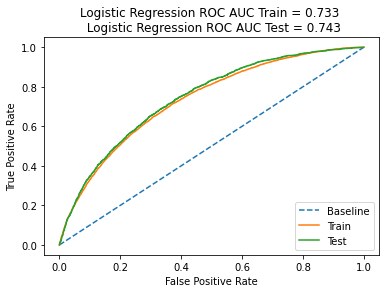

In [44]:
# строим графики метрик
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr_train, tpr_train, label = 'Train')
plt.plot(fpr_test, tpr_test, label = 'Test')
plt.title('Logistic Regression ROC AUC Train = {a} \n Logistic Regression ROC AUC Test = {b}'
          .format(a = roc_auc_train.round(3), b = roc_auc_test.round(3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
# ищем оптимальные значения гиперпараметров
model = LogisticRegression()
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']} 
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
## печатаем параметры
best_parameters = model.get_params()
for param_name in best_parameters:
        print(param_name, best_parameters[param_name], '\n')

In [ ]:
# Разобьем данные для обучения и тестирования по новой
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# строим модель
new_model = LogisticRegression(random_state = None, 
                               C = 1, 
                               class_weight = 'balanced', 
                               dual = False, 
                               fit_intercept = True, 
                               intercept_scaling = 1, 
                               l1_ratio = None, 
                               max_iter = 100, 
                               multi_class = 'auto', 
                               n_jobs = None, 
                               penalty = 'none', 
                               solver = 'newton-cg', 
                               tol = 0.0001,
                               verbose = 0, 
                               warm_start = False)
new_model.fit(X_train, y_train)

In [347]:
# считаем метрики обучающещей (X_train, y_train) выборки
y_train_probs = new_model.predict_proba(X_train)
y_train_probs = y_train_probs[:,1]
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_train_probs)
roc_auc_train = roc_auc_score(y_train, y_train_probs)

In [348]:
# считаем метрики тестовой (X_test, y_test) выборки
y_test_probs = new_model.predict_proba(X_test)
y_test_probs = y_test_probs[:,1]
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_probs)
roc_auc_test = roc_auc_score(y_test, y_test_probs)

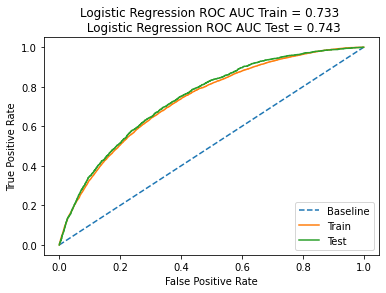

In [349]:
# строи графики метрик
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr_train, tpr_train, label = 'Train')
plt.plot(fpr_test, tpr_test, label = 'Test')
plt.title('Logistic Regression ROC AUC Train = {a} \n Logistic Regression ROC AUC Test = {b}'
          .format(a = roc_auc_train.round(3), b = roc_auc_test.round(3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### Делаем расчет

In [351]:
# выделяем тестовый датасет из датасета data
data_test = df[df['Train'] == 0]
data_test = data_test.drop(['client_id', 'app_date', 'Train'], axis=1)

In [352]:
# преобразуем категориальные переменные методом One-Hot Encoding
data_test_cat = OneHotEncoder(sparse = False).fit_transform(data_test[cat_cols].values)

In [353]:
# стандартизируем числовые переменные
data_test_num = StandardScaler().fit_transform(data_test[num_cols].values)

In [354]:
# объединяем категориальные, бинарные, числовые признаки в одно признаковое пространство
X = np.hstack([data_test_num, data_test[bin_cols].values, data_test_cat])

In [355]:
# делаем расчет
y = new_model.predict_proba(X)
y = y[:,1]

In [357]:
# создаем новый датасет
submit = pd.DataFrame(df_test.client_id)

In [358]:
# включаем в датасет расчитанные значения переменной default
submit['default'] = y

In [359]:
# выгружаем получившийся датасет в файл
submit.to_csv('submission.csv', index=False)